In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
### specifying parameters

# location of data file
filePath = 'spiking_data_for_modeling.mat'

# list, specifying data along which to cluster
classify = ['spikes_animal_idx','spikes_hemisphere_idx','spikes_genotype']

def compDiff(a,b,classify):
    comp = True
    for c in classify:
        #print(a[c],b[c])
        if type(a[c])==np.ndarray:
            comp = comp and np.array_equal(a[c],b[c])
            #print('is array')
        else:
            comp = comp and a[c]==b[c]
        #print(comp)
    #print('overall:',comp)
    return comp


### read data from file
f = h5py.File(filePath,'r')
data = {}
for key in f.keys():
    data[key] = np.array(f.get(key))

### preprocess data where needed
data['spikes_genotype'] = []
for spike_genotype_ref in data['spikes_genotype_idx']:
    data['spikes_genotype'].append(np.array(f[spike_genotype_ref[0]]))
data['spikes_animal_idx'] = data['spikes_animal_idx'].flatten()
data['spikes_cluster_idx'] = data['spikes_cluster_idx'].flatten()
data['spikes_hemisphere_idx'] = data['spikes_hemisphere_idx'].flatten()

In [3]:
### clustering data
spike_data = []
for n in range(len(data['spikes_animal_idx'])):
    
    ### create classification dictionary
    tmp_class = {}
    for c in classify:
        tmp_class[c] = data[c][n]
    #print(tmp_class)
    
    ### search, whether this set of data already exists
    idx = None
    for i,sd in enumerate(spike_data):
        #print('classification',sd['classification'])
        if compDiff(tmp_class,sd['classification'],classify):
            idx = i
            break
    
    ### create new cluster if idx not found
    if idx==None:
        idx = len(spike_data)
        spike_data.append({
            'classification': tmp_class,
            'spike_times': [],
            'neuron_idx': [],
            'cluster_idx': [],
        })
    
    spike_data[idx]['spike_times'].append(np.array(f[data['spikes_timestamps'][n][0]])[0])
    spike_data[idx]['neuron_idx'].append(n)
    spike_data[idx]['cluster_idx'].append(data['spikes_cluster_idx'][n])

In [4]:
for c in classify:
    print(c,data[c][3])

spikes_animal_idx 1.0
spikes_hemisphere_idx 1.0
spikes_genotype [[ 99]
 [114]
 [101]
 [ 45]]


In [5]:
max([max(s) for s in spike_data[0]['spike_times']])

608.0123333333333

In [6]:
### some processing

### sort neurons according to type
sort_keys = ['neuron_idx','cluster_idx','spike_times']
for sd in spike_data:
    sort_idx = np.argsort(sd['cluster_idx'])
    
    sd_tmp = {}
    for key in sort_keys:
        data_tmp = []
        for i,n in enumerate(sort_idx):
            data_tmp.append(sd[key][n])
        sd[key] = data_tmp
    sd['cluster_idx'] = np.array(sd['cluster_idx'])
        
### calculate some statistics
## firing rate
for sd in spike_data:
    sd['N'] = len(sd['neuron_idx']) # total number of recorded neurons
    sd['g'] = np.array([np.sum(np.array(sd['cluster_idx'])==a) for a in range(3)])/sd['N'] # fraction of neuron belonging to cluster a
    
    sd['T'] = max([max(s) for s in sd['spike_times']]) # recording time (estimated from very last spike encountered in this animal)
    
    nIntervals = 6
    dT = sd['T']/nIntervals
    sd['rate'] = np.zeros((sd['N'],nIntervals+1))
    for n,s in enumerate(sd['spike_times']):
        sd['rate'][n,0] = len(s)/sd['T']
        for i in range(nIntervals):
            sd['rate'][n,i+1] = np.sum((s>i*dT) & (s<(i+1)*dT))/dT

In [7]:
spike_data[0]['g']

array([0.28846154, 0.61538462, 0.09615385])

In [7]:
from matplotlib.widgets import Slider

def plot_animal(animal,ax,j=0):
    
    i=0
    for sd in spike_data:
        if sd['classification']['spikes_animal_idx'] == animal:

            for n in range(len(sd['neuron_idx'])):
                nAP = len(sd['spike_times'][n])
                col = 'gray'
                if sd['cluster_idx'][n] == 1.:
                    col = 'k'
                elif sd['cluster_idx'][n] == 2.:
                    col = 'r'
                ax[i][0].plot(sd['spike_times'][n],np.ones(nAP)*n,'.',markersize=2,color=col)
            ax[i][0].set_title(f'animal {int(animal)}' \
                                + f'{"l" if sd["classification"]["spikes_hemisphere_idx"]==1 else "r"}' \
                                + f' {"cre" if sd["classification"]["spikes_genotype"][1]==114 else "cTKO"}')
            ax[i][1].hist(sd['rate'][sd['cluster_idx']==1,j],np.linspace(0,5,51),facecolor='k',alpha=0.8)
            ax[i][1].hist(sd['rate'][sd['cluster_idx']==0,j],np.linspace(0,5,51),facecolor='gray',alpha=0.8)
            ax[i][1].hist(sd['rate'][sd['cluster_idx']==2,j],np.linspace(0,5,51),facecolor='r',alpha=0.8)
            
            i+=1
    plt.tight_layout()
    plt.show()

In [8]:
nAnimals = len(np.unique(data['spikes_animal_idx']))

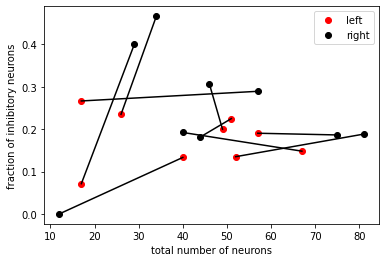

In [9]:
r = np.zeros((nAnimals,2))
N = np.zeros((nAnimals,2))

for sd in spike_data:
    a = int(sd['classification']['spikes_animal_idx'])-1
    h = int(sd['classification']['spikes_hemisphere_idx'])-1
    r[a,h] = sd['g'][2]/np.sum(sd['g'][1:])
    N[a,h] = sd['N']
plt.plot(N[:,0],r[:,0],'ro',label='left')
plt.plot(N[:,1],r[:,1],'ko',label='right')
plt.plot(N.T,r.T,'k-')

#print('fraction of inhibitory neurons: ', r)
plt.ylabel('fraction of inhibitory neurons')
plt.xlabel('total number of neurons')
plt.legend()

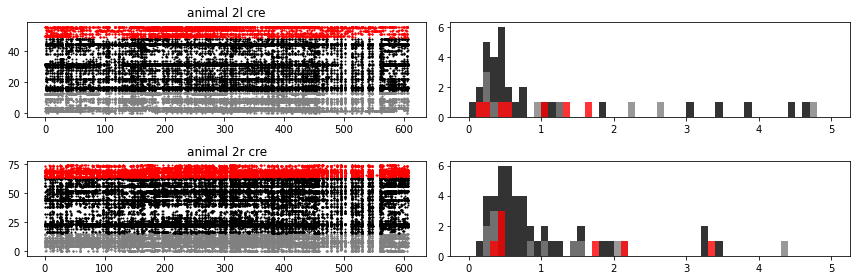

In [10]:
#fig,ax = plt.subplots(2,2,figsize=(12,4))

def change_slider(animal):
    print(animal)
    plot_animal(animal,ax)

animal = 2

#plot_animal(animal,ax,1)

fig,ax = plt.subplots(2,2,figsize=(12,4))
#axamp = plt.axes([0.02, .6, 0.4, 0.02])
#slider = Slider(axamp, 'animal', 1, 9, valinit=animal,orientation='horizontal')
#slider.on_changed(change_slider)
plot_animal(animal,ax,4)
